# Causal discovery with `TIGRAMITE`

TIGRAMITE is a time series analysis python module. It allows to reconstruct graphical models (conditional independence graphs) from discrete or continuously-valued time series based on the PCMCI framework and create high-quality plots of the results.

PCMCI is described here:
J. Runge, P. Nowack, M. Kretschmer, S. Flaxman, D. Sejdinovic, 
Detecting and quantifying causal associations in large nonlinear time series datasets. Sci. Adv. 5, eaau4996 (2019) 
https://advances.sciencemag.org/content/5/11/eaau4996

For further versions of PCMCI (e.g., PCMCI+, LPCMCI, etc.), see the corresponding tutorials.

This tutorial compares PCMCI with FullCI. See the following paper for theoretical background:
Runge, Jakob. 2018. “Causal Network Reconstruction from Time Series: From Theoretical Assumptions to Practical Estimation.” Chaos: An Interdisciplinary Journal of Nonlinear Science 28 (7): 075310.

Last, the following Nature Communications Perspective paper provides an overview of causal inference methods in general, identifies promising applications, and discusses methodological challenges (exemplified in Earth system sciences): 
https://www.nature.com/articles/s41467-019-10105-3

In [1]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
from tigramite.models import LinearMediation, Prediction


# PCMCI vs FullCI

An alternative way to estimate the time series graph is to directly test links by their defining equation (FullCI)

\begin{align*}
X^i_{t-\tau} \perp X^j_t ~|~ \mathbf{X}^-_t
\end{align*}

where $\mathbf{X}^-_t=(\mathbf{X}_{t-1}, \mathbf{X}_{t-2}, \ldots)$ is the past of the whole process. This is the approach of a *lag-specific* version of Granger causality or Transfer entropy. This approach gives lower detection power for two reasons:

1. Smaller *effect size* of FullCI compared to MCI
2. Higher dimensionality 

## 1. Smaller *effect size* of FullCI compared to MCI

Consider the following system:

\begin{align*} 
Z_t &= a Z_{t-1} + c_{XZ} X_{t-1} + \eta^Z_t  \\
X_t &= a_{X} X_{t-1} + c_{WX} W_{t-1} + \eta^X_t  \\
Y_t &= a Y_{t-1} + c_{XY} X_{t-2} + c_{WY} W_{t-3} + \eta^Y_t \\
W_t &= a W_{t-1} + \eta^W_t
\end{align*}

with independent Gaussian white noise processes $\eta^{\cdot}_t$ with variances $\sigma^2_{\cdot}$. Considering the link $X_{t-2}\to Y_t$, here it can be shown (see description paper) that the test statistic $I^{FullCI}(X_{t-2}\to Y_t) \leq I^{MCI}(X_{t-2}\to Y_t)$ generally. In the paper this is proven for arbitrary models. Measuring a smaller effect size implies a lower power to detect this particular link:

In [2]:
# Setup analysis
np.random.seed(42)     # Fix random seed
links_coeffs = {0: [((0, -1), 0.9), ((1, -1), -0.25)],
                1: [((1, -1), 0.95), ((3, -1), 0.3)],
                2: [((2, -1), 0.85), ((1, -2), 0.3), ((3, -3), 0.3)],
                3: [((3, -1), 0.8)],
                }
T = 100     # time series length
N = len(links_coeffs)
tau_max = 5
realizations = 100
alpha_level = 0.05

var_names = [r'$Z$', r'$X$', r'$Y$', r'$W$']
# # Define whole past
# whole_past = {}
# for j in range(N):
#     whole_past[j] = [(var, -lag)
#                          for var in range(N)
#                          for lag in range(1, tau_max + 1)
#                     ]
def get_sig_links():
    p_matrices = {'PCMCI':np.ones((realizations, N, N, tau_max+1)),
                  'FullCI':np.ones((realizations, N, N, tau_max+1))}
    val_matrices = {'PCMCI':np.zeros((realizations, N, N, tau_max+1)),
                  'FullCI':np.zeros((realizations, N, N, tau_max+1))}  
    for i in range(realizations):
        data, true_parents_neighbors = pp.var_process(links_coeffs, T=T)
        dataframe = pp.DataFrame(data)
        
        # PCMCI
        pcmci = PCMCI(dataframe=dataframe, cond_ind_test=ParCorr())
        results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=0.2)
        p_matrices['PCMCI'][i] = results['p_matrix']
        val_matrices['PCMCI'][i] = results['val_matrix']

        # Condition on whole past
        results = pcmci.run_fullci(tau_max=tau_max)
        p_matrices['FullCI'][i] = results['p_matrix']
        val_matrices['FullCI'][i] = results['val_matrix']

    # Get true positive rate (=power) and false positive rate 
    sig_links = {'PCMCI':(p_matrices['PCMCI'] <= alpha_level).mean(axis=0),
                  'FullCI':(p_matrices['FullCI'] <= alpha_level).mean(axis=0),}
    ave_val_matrices = {'PCMCI':val_matrices['PCMCI'].mean(axis=0),
                  'FullCI':val_matrices['FullCI'].mean(axis=0),}
    return sig_links, ave_val_matrices



In [3]:
sig_links, ave_val_matrices = get_sig_links()

We estimate how often a link was detected at the given ``alpha_level`` and plot this fraction as the width of the links while the average effect size for each link is given as the color:

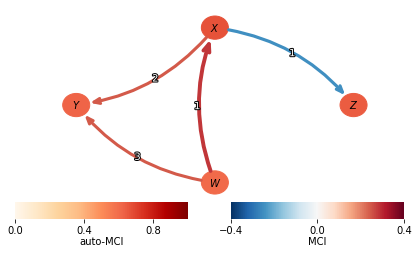

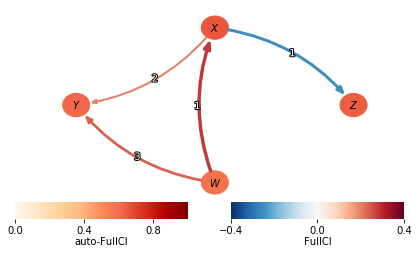

In [4]:
# Showing detection power as width of links
min_sig = 0.2
vminmax = 0.4
link_matrix = (sig_links['PCMCI'] > min_sig)
tp.plot_graph(val_matrix=ave_val_matrices['PCMCI'],
              link_matrix=link_matrix, var_names=var_names,
              link_width=sig_links['PCMCI'],
              vmin_edges=-vminmax,
              vmax_edges=vminmax,

)
link_matrix = (sig_links['FullCI'] > min_sig)
tp.plot_graph(val_matrix=ave_val_matrices['FullCI'],
              link_matrix=link_matrix, var_names=var_names,
              link_width=sig_links['FullCI'], 
              link_colorbar_label='FullCI',
              node_colorbar_label='auto-FullCI',
              vmin_edges=-vminmax,
              vmax_edges=vminmax,
); plt.show()

Evidently, the power of FullCI is lower mainly due to FullCI's test statistic effect size being smaller. MCI has been constructed to estimate a certain notion of *causal strength* as discussed in the paper. MCI, thus, alleviates the effect of other dependencies on a particular link. In large-scale studies, this feature allows to rank links by their causal strength.

## 2. Higher dimensionality 

An obvious drawback of FullCI is that it always includes the whole past as a condition leading to very high estimation dimension which results in lower power. In the following we consider a model with many irrelevant independent variables.

In [5]:
# Setup analysis
np.random.seed(42)     # Fix random seed
links_coeffs = {0: [((0, -1), 0.9), ((1, -1), -0.25)],
                1: [((1, -1), 0.95), ((3, -1), 0.3)],
                2: [((2, -1), 0.85), ((1, -2), 0.3), ((3, -3), 0.3)],
                3: [((3, -1), 0.8)],
                }
T = 80     # time series length
tau_max = 5
realizations = 100
alpha_level = 0.05
n_variables = 9

# Add independent autocorrelated variables
for d in range(4, n_variables):
    links_coeffs[d] = [((d, -1), 0.2 + np.random.rand()*0.7)]
    
var_names = [r'$Z$', r'$X$', r'$Y$', r'$W$'] + list(range(4, n_variables))

N = len(links_coeffs)
# # Define whole past
# whole_past = {}
# for j in range(N):
#     whole_past[j] = [(var, -lag)
#                          for var in range(N)
#                          for lag in range(1, tau_max + 1)
#                     ]

In [6]:
# This cell may take some minutes
sig_links, ave_val_matrices = get_sig_links()

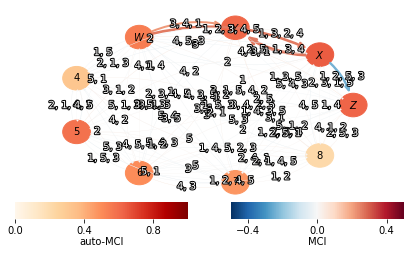

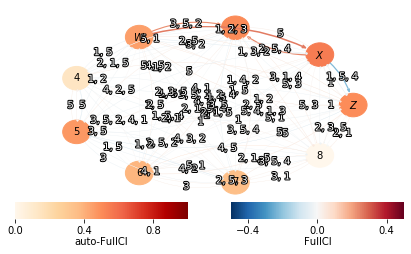

In [7]:
# Showing detection power as width of links
min_sig = 0.05
vminmax = 0.5
link_matrix = (sig_links['PCMCI'] > min_sig)
tp.plot_graph(val_matrix=ave_val_matrices['PCMCI'],
              link_matrix=link_matrix, 
              link_width=sig_links['PCMCI'],
              vmin_edges=-vminmax,
              vmax_edges=vminmax,
              var_names = var_names,

)
link_matrix = (sig_links['FullCI'] > min_sig)
tp.plot_graph(val_matrix=ave_val_matrices['FullCI'],
              link_matrix=link_matrix, 
              link_width=sig_links['FullCI'], 
              link_colorbar_label='FullCI',
              node_colorbar_label='auto-FullCI',
              vmin_edges=-vminmax,
              vmax_edges=vminmax,
             var_names = var_names,

); plt.show()

Here adding just 5 independent variables makes it already impossible to detect the true links with FullCI, while PCMCI still detects them with almost the same power as before while still well controlling false positives at the expected 5% level (note that only 100 realizations were used to estimate the false positive rates making them not very reliable while the true positive rates are more reliable):

In [8]:
true_links = np.zeros((N, N, tau_max+1))
for var in list(links_coeffs):
    for par in links_coeffs[var]:
        true_links[par[0][0], var, abs(par[0][1])] = True
# print true_links
print ("Mean true  positives PCMCI ", np.mean(sig_links['PCMCI'][:,:,1:]
                                                [true_links[:,:,1:]==True]).round(3))
print ("Mean false positives PCMCI ", np.mean(sig_links['PCMCI'][:,:,1:]
                                                [true_links[:,:,1:]==False]).round(3))
print ("Mean true  positives FullCI    ", np.mean(sig_links['FullCI'][:,:,1:]
                                                [true_links[:,:,1:]==True]).round(3))
print ("Mean false positives FullCI    ", np.mean(sig_links['FullCI'][:,:,1:]
                                                [true_links[:,:,1:]==False]).round(3))

Mean true  positives PCMCI  0.781
Mean false positives PCMCI  0.054
Mean true  positives FullCI     0.471
Mean false positives FullCI     0.052
